# Momotaro RAG Experiment - exp_004 (LM Studio + nomic-v2-moe)

このノートブックでは、桃太郎の物語に関するRAG（Retrieval-Augmented Generation）システムを**LM Studio + nomic-embed-text v2 (MoE)**で実装します。

## 目標
- 日本語の桃太郎テキストを読み込む
- テキストをチャンクに分割
- FAISSベクトルインデックスを作成（nomic-v2 MoE埋め込み使用）
- テスト質問に対してRAG有無での回答を比較
- exp_002 (nomic-v1) および exp_003 (Ollama + MoE) との比較

## 必要な準備
1. `data/raw/japanese/` に桃太郎のテキストファイルを3-5個配置
2. **LM Studioを起動してローカルサーバーを開始**
   - LM Studioで Phi-3.5-mini-instruct モデルを読み込む
   - 「Local Server」タブでサーバーを起動（デフォルト: http://localhost:1234）
3. Ollamaが起動していることを確認（エンベディング用）
   - `ollama pull nomic-embed-text-v2-moe`

## 1. セットアップとインポート

In [1]:
import os
import sys
import json
from pathlib import Path
from typing import List, Dict, Tuple
import re

# Data processing
import numpy as np
import pandas as pd
from dotenv import load_dotenv

# Vector store
import faiss

# LLM - OpenAI-compatible API
from openai import OpenAI

# Embedding - Ollama
import ollama

# Encoding detection
from charset_normalizer import from_path

# Load environment variables
load_dotenv()

# Configuration
LLM_PROVIDER = os.getenv('LLM_PROVIDER', 'lmstudio')
LMSTUDIO_BASE_URL = os.getenv('LMSTUDIO_BASE_URL', 'http://localhost:1234/v1')
LMSTUDIO_MODEL_NAME = os.getenv('LMSTUDIO_MODEL_NAME', 'phi-3.5-mini-instruct')
EMBEDDING_MODEL = 'nomic-embed-text-v2-moe'  # v2 MoEを使用
CHUNK_SIZE = int(os.getenv('CHUNK_SIZE', 500))
CHUNK_OVERLAP = int(os.getenv('CHUNK_OVERLAP', 50))
TOP_K = int(os.getenv('TOP_K_RESULTS', 3))
VECTOR_DIM = int(os.getenv('VECTOR_DIMENSION', 768))

# Initialize LM Studio client (OpenAI-compatible)
lm_client = OpenAI(
    base_url=LMSTUDIO_BASE_URL,
    api_key="lm-studio"  # LM Studio doesn't require a real API key
)

# Experiment Configuration
EXPERIMENT_ID = "exp_004_moe_lmstudio_phi35_nomic-v2-moe"

# Paths - 実験単位で管理
PROJECT_ROOT = Path.cwd().parent.parent  # From experiments/exp_XXX/ to project root
EXPERIMENT_PATH = PROJECT_ROOT / "experiments" / EXPERIMENT_ID
DATA_RAW_PATH = PROJECT_ROOT / "data" / "raw" / "japanese"
DATA_VECTORS_PATH = EXPERIMENT_PATH / "vectors"
RESULTS_PATH = EXPERIMENT_PATH / "results"
CONFIG_PATH = EXPERIMENT_PATH / "config.json"

# Create paths if they don't exist
DATA_VECTORS_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print("✓ Setup complete")
print(f"  - Experiment ID: {EXPERIMENT_ID}")
print(f"  - LLM Provider: {LLM_PROVIDER}")
print(f"  - LM Studio URL: {LMSTUDIO_BASE_URL}")
print(f"  - LM Studio Model: {LMSTUDIO_MODEL_NAME}")
print(f"  - Embedding Model: {EMBEDDING_MODEL} (MoE via Ollama)")
print(f"  - Data path: {DATA_RAW_PATH}")
print(f"  - Vectors path: {DATA_VECTORS_PATH}")
print(f"  - Results path: {RESULTS_PATH}")
print(f"\n⚠️  LM StudioとOllamaが起動していることを確認してください！")

✓ Setup complete
  - Experiment ID: exp_004_moe_lmstudio_phi35_nomic-v2-moe
  - LLM Provider: lmstudio  # Options: lmstudio, ollama, openai
  - LM Studio URL: http://localhost:1234/v1
  - LM Studio Model: phi-3.5-mini-instruct
  - Embedding Model: nomic-embed-text-v2-moe (MoE via Ollama)
  - Data path: /Users/igomuni/MyGitHub/RagLab001/data/raw/japanese
  - Vectors path: /Users/igomuni/MyGitHub/RagLab001/experiments/exp_004_moe_lmstudio_phi35_nomic-v2-moe/vectors
  - Results path: /Users/igomuni/MyGitHub/RagLab001/experiments/exp_004_moe_lmstudio_phi35_nomic-v2-moe/results

⚠️  LM StudioとOllamaが起動していることを確認してください！


## 2. LM Studio接続テスト

In [3]:
# LM Studioサーバーへの接続をテスト
print("Testing LM Studio connection...")
try:
    # 利用可能なモデルのリストを取得
    models = lm_client.models.list()
    print("✓ LM Studio connection successful!")
    print(f"\nAvailable models:")
    for model in models.data:
        print(f"  - {model.id}")
    
    # 簡単なテスト生成
    print("\nTesting generation...")
    test_response = lm_client.chat.completions.create(
        model=LMSTUDIO_MODEL_NAME,
        messages=[
            {"role": "user", "content": "こんにちは！"}
        ],
        temperature=0.7,
        max_tokens=50
    )
    print(f"Test response: {test_response.choices[0].message.content}")
    print("\n✓ LM Studio is working correctly!")
    
except Exception as e:
    print(f"\n❌ Error connecting to LM Studio: {e}")
    print("\nPlease ensure:")
    print("1. LM Studio is running")
    print("2. A model is loaded in LM Studio")
    print("3. The local server is started (usually http://localhost:1234)")
    print(f"4. The base URL in .env matches: {LMSTUDIO_BASE_URL}")

Testing LM Studio connection...
✓ LM Studio connection successful!

Available models:
  - phi-3.5-mini-instruct
  - qwen2.5-7b-instruct-1m
  - gemma-2-9b-it
  - text-embedding-nomic-embed-text-v1.5

Testing generation...
Test response: こんにちは！今日はどのようお手伝いできますか？

✓ LM Studio is working correctly!


## 3. データロードと前処理

In [4]:
def detect_encoding(file_path: Path) -> str:
    """
    ファイルのエンコーディングを自動検出
    """
    result = from_path(file_path).best()
    return result.encoding if result else 'utf-8'

def load_text_file(file_path: Path) -> Dict[str, str]:
    """
    テキストファイルを読み込み、メタデータとともに返す
    """
    encoding = detect_encoding(file_path)
    
    try:
        with open(file_path, 'r', encoding=encoding) as f:
            content = f.read()
        
        return {
            'source': file_path.name,
            'path': str(file_path),
            'language': 'ja',
            'encoding': encoding,
            'content': content,
            'char_count': len(content)
        }
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

def preprocess_text(text: str) -> str:
    """
    テキストの前処理
    - 余分な空白を削除
    - 改行を正規化
    """
    # 連続する空白を1つに
    text = re.sub(r'[ \t]+', ' ', text)
    
    # 3つ以上の連続する改行を2つに
    text = re.sub(r'\n{3,}', '\n\n', text)
    
    # 行頭・行末の空白を削除
    text = '\n'.join(line.strip() for line in text.split('\n'))
    
    return text.strip()

# データの読み込み
print("Loading Japanese Momotaro texts...")
text_files = list(DATA_RAW_PATH.glob('*.txt'))

if not text_files:
    print(f"⚠ No text files found in {DATA_RAW_PATH}")
    print("Please add Momotaro text files to data/raw/japanese/")
    documents = []
else:
    documents = []
    for file_path in text_files:
        doc = load_text_file(file_path)
        if doc:
            doc['content'] = preprocess_text(doc['content'])
            documents.append(doc)
            print(f"  ✓ Loaded: {doc['source']} ({doc['char_count']:,} chars, {doc['encoding']})")
    
    print(f"\n✓ Total documents loaded: {len(documents)}")

Loading Japanese Momotaro texts...
  ✓ Loaded: aozora_jp_001.txt (2,001 chars, utf_8)
  ✓ Loaded: children_jp_003.txt (1,454 chars, utf_8)
  ✓ Loaded: traditional_jp_002.txt (3,197 chars, utf_8)

✓ Total documents loaded: 3


## 4. テキストのチャンク化

In [5]:
def chunk_by_paragraphs(text: str, max_chars: int = CHUNK_SIZE, overlap: int = CHUNK_OVERLAP) -> List[str]:
    """
    段落ベースでテキストをチャンク化
    段落が長すぎる場合は文単位で分割
    """
    # 段落で分割（空行で区切られた部分）
    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
    
    chunks = []
    current_chunk = ""
    
    for para in paragraphs:
        # 段落が最大サイズを超える場合
        if len(para) > max_chars:
            # 現在のチャンクを保存
            if current_chunk:
                chunks.append(current_chunk.strip())
                current_chunk = ""
            
            # 長い段落を文単位で分割
            sentences = re.split(r'([。！？])', para)
            sentences = [''.join(sentences[i:i+2]) for i in range(0, len(sentences), 2)]
            
            for sent in sentences:
                if len(current_chunk) + len(sent) <= max_chars:
                    current_chunk += sent
                else:
                    if current_chunk:
                        chunks.append(current_chunk.strip())
                    current_chunk = sent
        else:
            # 段落を追加できるか確認
            if len(current_chunk) + len(para) + 2 <= max_chars:  # +2 for \n\n
                if current_chunk:
                    current_chunk += "\n\n" + para
                else:
                    current_chunk = para
            else:
                if current_chunk:
                    chunks.append(current_chunk.strip())
                current_chunk = para
    
    # 最後のチャンクを追加
    if current_chunk:
        chunks.append(current_chunk.strip())
    
    return chunks

def create_chunks_with_metadata(documents: List[Dict]) -> List[Dict]:
    """
    全ドキュメントをチャンク化し、メタデータを付加
    """
    all_chunks = []
    
    for doc in documents:
        chunks = chunk_by_paragraphs(doc['content'], CHUNK_SIZE, CHUNK_OVERLAP)
        
        for idx, chunk_text in enumerate(chunks):
            chunk = {
                'chunk_id': f"{doc['source']}_{idx:03d}",
                'text': chunk_text,
                'source': doc['source'],
                'language': doc['language'],
                'position': idx,
                'char_count': len(chunk_text)
            }
            all_chunks.append(chunk)
    
    return all_chunks

# チャンク作成
if documents:
    print("Creating chunks...")
    chunks = create_chunks_with_metadata(documents)
    print(f"✓ Created {len(chunks)} chunks")
    
    # チャンクのサンプル表示
    if chunks:
        print("\nSample chunks:")
        for i, chunk in enumerate(chunks[:3]):
            print(f"\n--- Chunk {i+1}: {chunk['chunk_id']} ---")
            print(f"Source: {chunk['source']}")
            print(f"Length: {chunk['char_count']} chars")
            print(f"Text preview: {chunk['text'][:100]}...")
else:
    chunks = []
    print("⚠️  No documents to chunk. Please add text files first.")

Creating chunks...
✓ Created 15 chunks

Sample chunks:

--- Chunk 1: aozora_jp_001.txt_000 ---
Source: aozora_jp_001.txt
Length: 493 chars
Text preview: 桃太郎

むかしむかし、あるところに、おじいさんとおばあさんが住んでいました。

一、桃太郎の誕生

おじいさんは山へ柴刈りに、おばあさんは川へ洗濯に行きました。おばあさんが川で洗濯をしていると、どん...

--- Chunk 2: aozora_jp_001.txt_001 ---
Source: aozora_jp_001.txt
Length: 462 chars
Text preview: ある日、桃太郎はおじいさんとおばあさんに言いました。

「鬼ヶ島へ行って、鬼を退治してきます。村のみんなのためにも、育ててくれたお二人のためにも、僕が鬼をやっつけます」

おばあさんは心配しましたが、...

--- Chunk 3: aozora_jp_001.txt_002 ---
Source: aozora_jp_001.txt
Length: 434 chars
Text preview: 桃太郎は猿にもきびだんごを一つあげました。猿も喜んで、桃太郎のお供になりました。

さらに進んでいくと、今度は一羽のキジに出会いました。

「桃太郎さん、どこへ行かれるのですか」
「鬼ヶ島へ、鬼退治に...


## 5. エンベディング生成とFAISSインデックス構築

エンベディングはOllamaのnomic-embed-textを使用します。

In [6]:
def generate_embedding(text: str, model: str = EMBEDDING_MODEL) -> np.ndarray:
    """
    Ollamaを使ってテキストのエンベディングを生成
    """
    try:
        response = ollama.embeddings(model=model, prompt=text)
        return np.array(response['embedding'], dtype=np.float32)
    except Exception as e:
        print(f"Error generating embedding: {e}")
        return None

def generate_embeddings_batch(texts: List[str], model: str = EMBEDDING_MODEL) -> np.ndarray:
    """
    複数テキストのエンベディングを生成
    """
    embeddings = []
    
    for i, text in enumerate(texts):
        if (i + 1) % 10 == 0:
            print(f"  Processing {i+1}/{len(texts)}...")
        
        emb = generate_embedding(text, model)
        if emb is not None:
            embeddings.append(emb)
        else:
            # エラーの場合はゼロベクトル
            embeddings.append(np.zeros(VECTOR_DIM, dtype=np.float32))
    
    return np.array(embeddings)

def create_faiss_index(embeddings: np.ndarray) -> faiss.Index:
    """
    FAISSインデックスを作成
    """
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)  # L2距離を使用
    index.add(embeddings)
    return index

# エンベディング生成
if chunks:
    print("Generating embeddings...")
    print("This may take a few minutes depending on the number of chunks.")
    print("⚠️  Ollamaが起動していることを確認してください！")
    
    chunk_texts = [chunk['text'] for chunk in chunks]
    embeddings = generate_embeddings_batch(chunk_texts)
    
    print(f"✓ Generated {len(embeddings)} embeddings")
    print(f"  Embedding dimension: {embeddings.shape[1]}")
    
    # FAISSインデックス作成
    print("\nCreating FAISS index...")
    index = create_faiss_index(embeddings)
    print(f"✓ FAISS index created with {index.ntotal} vectors")
    
    # インデックスとメタデータを保存
    index_path = DATA_VECTORS_PATH / "index.faiss"
    metadata_path = DATA_VECTORS_PATH / "metadata.json"
    
    faiss.write_index(index, str(index_path))
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump(chunks, f, ensure_ascii=False, indent=2)
    
    print(f"\n✓ Saved index to {index_path}")
    print(f"✓ Saved metadata to {metadata_path}")
else:
    print("⚠️  No chunks to embed. Please add text files and create chunks first.")

Generating embeddings...
This may take a few minutes depending on the number of chunks.
⚠️  Ollamaが起動していることを確認してください！
  Processing 10/15...
✓ Generated 15 embeddings
  Embedding dimension: 768

Creating FAISS index...
✓ FAISS index created with 15 vectors

✓ Saved index to /Users/igomuni/MyGitHub/RagLab001/experiments/exp_004_moe_lmstudio_phi35_nomic-v2-moe/vectors/index.faiss
✓ Saved metadata to /Users/igomuni/MyGitHub/RagLab001/experiments/exp_004_moe_lmstudio_phi35_nomic-v2-moe/vectors/metadata.json


## 6. 検索機能の実装

In [7]:
def search_similar_chunks(query: str, index: faiss.Index, chunks: List[Dict], k: int = TOP_K) -> List[Dict]:
    """
    クエリに類似したチャンクを検索
    """
    # クエリのエンベディング生成
    query_embedding = generate_embedding(query)
    if query_embedding is None:
        return []
    
    # 検索実行
    query_embedding = query_embedding.reshape(1, -1)
    distances, indices = index.search(query_embedding, k)
    
    # 結果を整形
    results = []
    for dist, idx in zip(distances[0], indices[0]):
        if idx < len(chunks):
            result = chunks[idx].copy()
            result['distance'] = float(dist)
            result['similarity'] = 1 / (1 + dist)  # 類似度スコア
            results.append(result)
    
    return results

# 検索のテスト
if chunks and 'index' in locals():
    print("Testing retrieval...")
    test_query = "桃太郎はどこから生まれましたか"
    results = search_similar_chunks(test_query, index, chunks, k=3)
    
    print(f"\nQuery: {test_query}")
    print(f"Found {len(results)} relevant chunks:\n")
    
    for i, result in enumerate(results, 1):
        print(f"Result {i}:")
        print(f"  Source: {result['source']}")
        print(f"  Chunk ID: {result['chunk_id']}")
        print(f"  Similarity: {result['similarity']:.4f}")
        print(f"  Text: {result['text'][:150]}...")
        print()
else:
    print("⚠️  Please create chunks and index first.")

Testing retrieval...

Query: 桃太郎はどこから生まれましたか
Found 3 relevant chunks:

Result 1:
  Source: aozora_jp_001.txt
  Chunk ID: aozora_jp_001.txt_000
  Similarity: 0.0063
  Text: 桃太郎

むかしむかし、あるところに、おじいさんとおばあさんが住んでいました。

一、桃太郎の誕生

おじいさんは山へ柴刈りに、おばあさんは川へ洗濯に行きました。おばあさんが川で洗濯をしていると、どんぶらこ、どんぶらこと、大きな桃が流れてきました。

「これは良い桃じゃ。持って帰っておじいさんと食べ...

Result 2:
  Source: traditional_jp_002.txt
  Chunk ID: traditional_jp_002.txt_001
  Similarity: 0.0061
  Text: 二人は包丁を持ってきて、桃を切ろうとしました。ところが、包丁を当てた瞬間、桃がひとりでにパカッと二つに割れました。

すると驚いたことに、桃の中から元気な産声が聞こえてきて、かわいらしい男の赤ちゃんが現れたのです。

「おぎゃあ、おぎゃあ」

赤ちゃんは手足を元気に動かして、二人の顔を見上げています...

Result 3:
  Source: traditional_jp_002.txt
  Chunk ID: traditional_jp_002.txt_006
  Similarity: 0.0052
  Text: 「桃太郎さまが帰ってきた！」
「鬼を退治してくれた！」

人々は歓声を上げ、桃太郎たちを英雄として迎えました。

おじいさんとおばあさんは、無事に帰ってきた桃太郎を抱きしめて、喜びの涙を流しました。

桃太郎が持ち帰った宝物は村人たちに分け与えられ、村は豊かになりました。鬼たちは約束を守り、二度と村...



## 7. LLM統合（LM Studio + Phi3.5）

In [8]:
def generate_response_lmstudio(
    prompt: str, 
    model: str = LMSTUDIO_MODEL_NAME,
    temperature: float = 0.7, 
    max_tokens: int = 500
) -> str:
    """
    LM Studioを使って応答を生成
    """
    try:
        response = lm_client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=temperature,
            max_tokens=max_tokens
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error generating response: {e}")
        return ""

def build_rag_prompt(query: str, context_chunks: List[Dict]) -> str:
    """
    RAG用のプロンプトを構築
    """
    context_text = "\n\n".join([
        f"[参考{i+1}] {chunk['text']}"
        for i, chunk in enumerate(context_chunks)
    ])
    
    prompt = f"""以下の参考情報を使って質問に答えてください。

【参考情報】
{context_text}

【質問】
{query}

【回答】
"""
    return prompt

def build_no_rag_prompt(query: str) -> str:
    """
    RAG無しのプロンプトを構築
    """
    prompt = f"""以下の質問に答えてください。

【質問】
{query}

【回答】
"""
    return prompt

# LLMのテスト
if chunks and 'index' in locals():
    print("Testing LLM generation with LM Studio...\n")
    
    test_query = "桃太郎はどこから生まれましたか"
    
    # RAGありの応答
    print("=== RAG Response ===")
    context = search_similar_chunks(test_query, index, chunks, k=3)
    rag_prompt = build_rag_prompt(test_query, context)
    rag_response = generate_response_lmstudio(rag_prompt)
    print(rag_response)
    
    print("\n" + "="*50 + "\n")
    
    # RAG無しの応答
    print("=== Non-RAG Response ===")
    no_rag_prompt = build_no_rag_prompt(test_query)
    no_rag_response = generate_response_lmstudio(no_rag_prompt)
    print(no_rag_response)
else:
    print("⚠️  Please create chunks and index first.")

Testing LLM generation with LM Studio...

=== RAG Response ===
桃太郎は、おばあさんが川で洗濯をするときに流れてきた大きな桃から生まれました。この出来事は「桃から生まれた男の赤ちゃん」という物語の中で説明されており、それが彼の命名につながっていることを示しています。


=== Non-RAG Response ===
提供された情報に基づいて正確な回答を出すのは困難です。桃太郎がどこから生まれたか、詳しい物語や文脈が提供されていない限り、正確な回答を与えるのは不可能です。

【仮定的な回答】
もし話の中に桃太郎が日本国内で生まれたと記述されている場合、次のように提供できるかもしれません：「桃太郎は日本で生まれました。」

注意：これは仮定的な回答であり、実際の情報が不足している場合に対する一般的なアプローチです。


## 8. 評価実験：複数の質問で比較

In [9]:
# テスト質問セット
test_questions = [
    {
        'id': 'q1',
        'category': 'plot',
        'question': '桃太郎はどこから生まれましたか？'
    },
    {
        'id': 'q2',
        'category': 'plot',
        'question': '桃太郎は誰と一緒に鬼ヶ島へ行きましたか？'
    },
    {
        'id': 'q3',
        'category': 'detail',
        'question': '桃太郎は動物たちに何をあげましたか？'
    },
    {
        'id': 'q4',
        'category': 'plot',
        'question': '桃太郎は鬼ヶ島で何をしましたか？'
    },
    {
        'id': 'q5',
        'category': 'theme',
        'question': '桃太郎の物語が教える教訓は何ですか？'
    }
]

print(f"Running evaluation with {len(test_questions)} questions...\n")

Running evaluation with 5 questions...



In [10]:
from datetime import datetime

def run_comparison_experiment(questions: List[Dict], index: faiss.Index, chunks: List[Dict]) -> List[Dict]:
    """
    全ての質問に対してRAG有無の比較実験を実行
    """
    results = []
    
    for i, q in enumerate(questions, 1):
        print(f"\n{'='*60}")
        print(f"Question {i}/{len(questions)}: {q['question']}")
        print(f"{'='*60}")
        
        # RAGありの応答
        print("\nGenerating RAG response...")
        context = search_similar_chunks(q['question'], index, chunks, k=TOP_K)
        rag_prompt = build_rag_prompt(q['question'], context)
        rag_response = generate_response_lmstudio(rag_prompt)
        
        print("RAG Response:")
        print(rag_response)
        
        # RAG無しの応答
        print("\nGenerating Non-RAG response...")
        no_rag_prompt = build_no_rag_prompt(q['question'])
        no_rag_response = generate_response_lmstudio(no_rag_prompt)
        
        print("Non-RAG Response:")
        print(no_rag_response)
        
        # 結果を保存
        result = {
            'question_id': q['id'],
            'category': q['category'],
            'question': q['question'],
            'timestamp': datetime.now().isoformat(),
            'llm_provider': 'lmstudio',
            'model': LMSTUDIO_MODEL_NAME,
            'rag': {
                'response': rag_response,
                'context_chunks': [{
                    'chunk_id': c['chunk_id'],
                    'source': c['source'],
                    'text': c['text'],
                    'similarity': c['similarity']
                } for c in context],
                'response_length': len(rag_response)
            },
            'no_rag': {
                'response': no_rag_response,
                'response_length': len(no_rag_response)
            }
        }
        
        results.append(result)
    
    return results

# 実験実行
if chunks and 'index' in locals():
    experiment_results = run_comparison_experiment(test_questions, index, chunks)
else:
    print("⚠️  Please create chunks and index first.")
    experiment_results = []


Question 1/5: 桃太郎はどこから生まれましたか？

Generating RAG response...
RAG Response:
桃太郎は、川で大きな桃から生まれました。おばあさんが川で洗濯をするときに流れてくるこの桃から赤ちゃん男性（桃太郎）が卵から誕生したという物語で、それが日本民話「桃太郎」の中心テーマです。

Generating Non-RAG response...
Non-RAG Response:
提供された情報では、桃太郎の出生地について明示されていないため、詳細を具体的に知ることは不可能です。正しい回答を提供するためには、より多くの文脈や情報が必要です。

例えば：

【追加情報】
桃太郎は日本の東京都出身であり、生まれた年が1980年だったと記されている場合、それに基づき回答することが可能です。

【回答】桃太郎は東京都出身で生まれた。

Question 2/5: 桃太郎は誰と一緒に鬼ヶ島へ行きましたか？

Generating RAG response...
RAG Response:
桃太郎はキジ、犬、猿の三匹と一緒に鬼ヶ島へ向かいました。最後に追加された参考情報（[参考3]）でも言及されており、キジが桃太郎の供になったことを確認する手がかりです。したがって、正解は「キジ」です。

Generating Non-RAG response...
Non-RAG Response:
桃太郎が鬼ヶ島を訪れる際、彼の仲間である佐々木次郎と一緒に行ったことが多くの日本の民話やお経に記されています。しかしながら、正確な回答は質問文や提供された情報内容に基づくものである必要があります。与えられた情報だけでは佐々木次郎という名前しか明示されておらず、特定の物語や文献を参考にしない限り正確な回答を提供することは適切ではありません。

【修正回答】
桃太郎が鬼ヶ島へ行った時の誰と一緒にいたか、情報不足で判断することは難しいです。なお、日本の伝説や民話「旅っ子佐々木次郎」を参照してみましょう：それによると、桃太郎が鬼ヶ島へ行く際は、彼の仲間である佐々木次郎と一緒にいたとされています。

注意:この回答は「旅っ子佐々木次郎」を参考文献とし、情報提供が限られる中で仮定的な解釈に基づいております。



Question 3/5: 桃太郎は動物たち

## 9. 結果の保存と分析

In [11]:
# 結果をJSONファイルに保存
if experiment_results:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = RESULTS_PATH / f"experiment_results_{timestamp}.json"
    
    with open(results_file, 'w', encoding='utf-8') as f:
        json.dump(experiment_results, f, ensure_ascii=False, indent=2)
    
    print(f"\n✓ Results saved to {results_file}")
else:
    print("⚠️  No results to save.")


✓ Results saved to /Users/igomuni/MyGitHub/RagLab001/experiments/exp_004_moe_lmstudio_phi35_nomic-v2-moe/results/experiment_results_20260113_134129.json


In [12]:
# 結果の統計分析
if experiment_results:
    print("\n" + "="*60)
    print("EXPERIMENT SUMMARY (exp_004 - LM Studio + nomic-v2 MoE)")
    print("="*60 + "\n")
    
    rag_lengths = [r['rag']['response_length'] for r in experiment_results]
    no_rag_lengths = [r['no_rag']['response_length'] for r in experiment_results]
    
    print(f"Total questions: {len(experiment_results)}")
    print(f"Experiment ID: {EXPERIMENT_ID}")
    print(f"LLM: {LMSTUDIO_MODEL_NAME} (via LM Studio)")
    print(f"Embedding Model: {EMBEDDING_MODEL} (MoE)")
    print(f"\nResponse lengths:")
    print(f"  RAG average: {np.mean(rag_lengths):.1f} chars")
    print(f"  Non-RAG average: {np.mean(no_rag_lengths):.1f} chars")
    print(f"\nRAG used context from:")
    
    # 使用されたソースの集計
    sources_used = {}
    for r in experiment_results:
        for chunk in r['rag']['context_chunks']:
            source = chunk['source']
            sources_used[source] = sources_used.get(source, 0) + 1
    
    for source, count in sorted(sources_used.items(), key=lambda x: x[1], reverse=True):
        print(f"  {source}: {count} times")
    
    print("\n" + "="*60)
    print("\n比較用メモ:")
    print("  - exp_002との比較: 埋め込みモデルの違い (v1 vs v2 MoE)")
    print("  - exp_003との比較: LLMモデルの違い (phi3 vs phi-3.5)")
    print("  - exp_001と4実験の総合比較: LLM×埋め込みの組み合わせ効果")
    print("\nManual evaluation template:")
    print("For each question, rate both responses on:")
    print("  1. Accuracy (1-5): Is the answer factually correct?")
    print("  2. Completeness (1-5): Does it cover all aspects?")
    print("  3. Coherence (1-5): Is it well-structured?")
    print("  4. Relevance (1-5): Does it answer the question?")
    print("\nResults are saved in JSON format for manual annotation.")
else:
    print("⚠️  No results to analyze.")


EXPERIMENT SUMMARY (exp_004 - LM Studio + nomic-v2 MoE)

Total questions: 5
Experiment ID: exp_004_moe_lmstudio_phi35_nomic-v2-moe
LLM: phi-3.5-mini-instruct (via LM Studio)
Embedding Model: nomic-embed-text-v2-moe (MoE)

Response lengths:
  RAG average: 145.6 chars
  Non-RAG average: 325.2 chars

RAG used context from:
  aozora_jp_001.txt: 9 times
  traditional_jp_002.txt: 6 times


比較用メモ:
  - exp_002との比較: 埋め込みモデルの違い (v1 vs v2 MoE)
  - exp_003との比較: LLMモデルの違い (phi3 vs phi-3.5)
  - exp_001と4実験の総合比較: LLM×埋め込みの組み合わせ効果

Manual evaluation template:
For each question, rate both responses on:
  1. Accuracy (1-5): Is the answer factually correct?
  2. Completeness (1-5): Does it cover all aspects?
  3. Coherence (1-5): Is it well-structured?
  4. Relevance (1-5): Does it answer the question?

Results are saved in JSON format for manual annotation.


## 10. 結果の可視化（オプション）

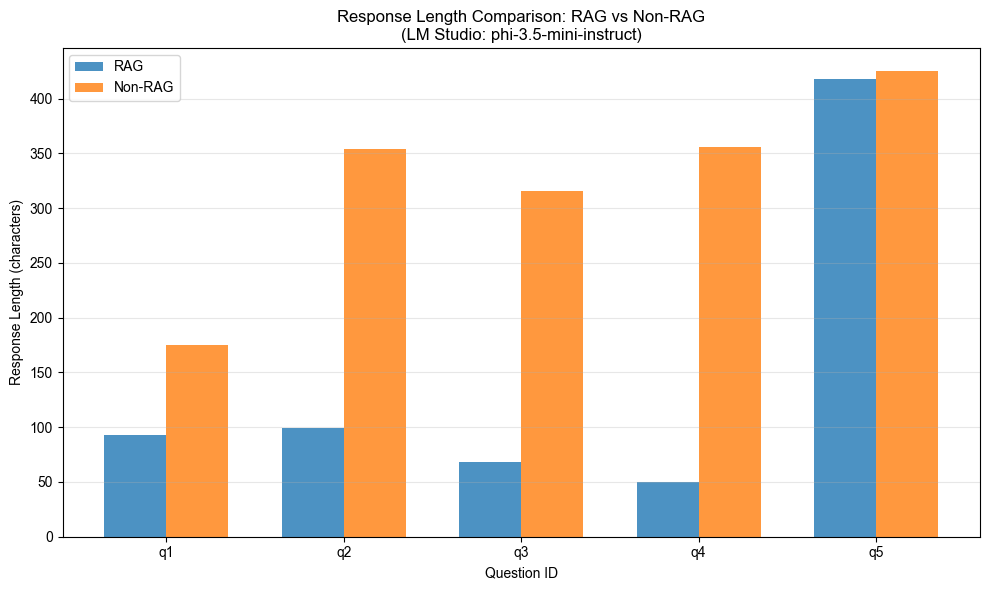


✓ Visualization complete


In [13]:
if experiment_results:
    import matplotlib.pyplot as plt
    import matplotlib
    
    # 日本語フォントの設定
    matplotlib.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Hiragino Sans', 'Yu Gothic', 'Meiryo']
    matplotlib.rcParams['axes.unicode_minus'] = False
    
    # 応答長の比較
    fig, ax = plt.subplots(figsize=(10, 6))
    
    question_ids = [r['question_id'] for r in experiment_results]
    x = np.arange(len(question_ids))
    width = 0.35
    
    ax.bar(x - width/2, rag_lengths, width, label='RAG', alpha=0.8)
    ax.bar(x + width/2, no_rag_lengths, width, label='Non-RAG', alpha=0.8)
    
    ax.set_xlabel('Question ID')
    ax.set_ylabel('Response Length (characters)')
    ax.set_title(f'Response Length Comparison: RAG vs Non-RAG\n(LM Studio: {LMSTUDIO_MODEL_NAME})')
    ax.set_xticks(x)
    ax.set_xticklabels(question_ids)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization complete")
else:
    print("⚠️  No results to visualize.")

## 11. 次のステップ

このexp_004 (LM Studio + MoE埋め込み版) 実験の完了後:

1. **4実験の総合比較**: exp_001~004の結果を統合して分析
   - LLMモデルの影響 (phi3 vs phi-3.5)
   - 埋め込みモデルの影響 (nomic-v1 vs nomic-v2 MoE)
   - 組み合わせ効果の評価

2. **比較軸**:
   - 検索精度: 関連チャンクの取得率
   - 応答品質: RAG応答の正確性と詳細度
   - 計算コスト: 埋め込み生成時間とLLM応答時間

3. **総合レポート作成**: 4つの実験を比較したドキュメント作成

**重要な発見事項の記録**:
- MoE埋め込みの効果
- Phi-3 vs Phi-3.5の性能差
- 最適な組み合わせの推奨

---

**実験完了！**  
全4実験の結果を総合的に比較し、最適な構成を特定してください。